In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from train_test_maker import train_test

Estrategia 1: Base line (Naive-Bayes) 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

X_train, y_train, X_test, y_test = train_test()

classificador = Pipeline([
                        ('meu_vetorizador', CountVectorizer()),
                        ('meu_classificador', BernoulliNB())
                        ])


classificador.fit(X_train, y_train)

y_pred = y_test

y_pred = classificador.predict(X_test)
print(y_pred)
acc = accuracy_score(y_test, y_pred)
print(acc)

[0. 0. 1. ... 1. 0. 0.]
0.9812578419071518


Estrategia 2: Rede profunda treinada In-House (deep_cnn_embedding_softmax)

In [6]:
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Input, Concatenate, Dense, Activation, TextVectorization, Embedding, GlobalAveragePooling1D, Conv1D, AveragePooling1D, Reshape, GRU, LSTM
from keras.models import Model
import tensorflow as tf
from train_test_maker import train_test
from sklearn.model_selection import train_test_split

2023-06-06 12:57:55.876861: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 12:57:56.085536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 12:57:56.087691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 12:57:57.129007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
def convolve_and_downsample(input_n_samples, input_embedding_size, n_filters, kernel_size=3, **kwargs): #camada costumizada, convolucao com downsampling
    input_layer = Input(shape=(input_n_samples,input_embedding_size)) 
    x = input_layer
    x = Conv1D( filters=n_filters, #o numero de filtros que voce quer aplicar, dita a dimensao da sua saida.
                kernel_size=kernel_size, #tamanho do seu filtro h da convolucao 
                padding='same',
                use_bias=False,
                )(x) #convolucao
    x = AveragePooling1D(pool_size=2)(x) #downsampling, poolsize 2 significa que voce vai pegar o valor medio a cada 2 elementos.
    x = Activation('elu')(x) #funcao de ativação
    return Model(input_layer, x, **kwargs) #retorna o modelo

cds = convolve_and_downsample(8, 2, 4, 3, name='ngrama') #numero de amostras na entrada, dimensao do embedding, numero de filtros, tamanho do filtro
print(cds.summary())

Model: "ngrama"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 2)]            0         
                                                                 
 conv1d (Conv1D)             (None, 8, 4)              24        
                                                                 
 average_pooling1d (AverageP  (None, 4, 4)             0         
 ooling1D)                                                       
                                                                 
 activation (Activation)     (None, 4, 4)              0         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
None


2023-06-06 12:57:58.080972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
vocab_size = 1000

def deep_cnn_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size, number_of_ngrams=24, n_gram_size=4):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    #abaixo estamos fazendo N gramas de N gramas, juntna as palavras em N gramas e depois junta esses N gramas em N gramas ate termos um grande N grama de X palavras.
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x = convolve_and_downsample(128, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(64, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(32, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(16, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(8, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(4, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(2, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = Reshape( (-1,))(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)



X_train, y_train, X_test, y_test = train_test()


y = np.concatenate((y_train, y_test), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

y = np.asarray(y)
X = np.asarray(X)

ohe = OneHotEncoder()

y_ohe = ohe.fit_transform(y.reshape((-1,1))).todense()
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe)

vectorize_layer = TextVectorization(max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=256)
vectorize_layer.adapt(X_train)
clf2 = deep_cnn_embedding_softmax_model(vectorize_layer)
print(clf2.summary())
clf2.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history = clf2.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.1)
clf2.evaluate(X_test, y_test)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 projecao (Embedding)        (None, 256, 2)            2000      
                                                                 
 ngramas (Functional)        (None, 128, 24)           192       
                                                                 
 model (Functional)          (None, 64, 24)            2304      
                                                                 
 model_1 (Functional)        (None, 32, 24)            2304      
                                                           

[0.09073994308710098, 0.9677500128746033]

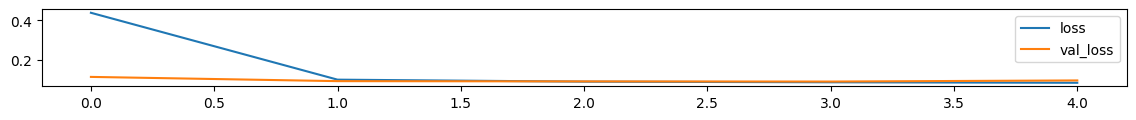

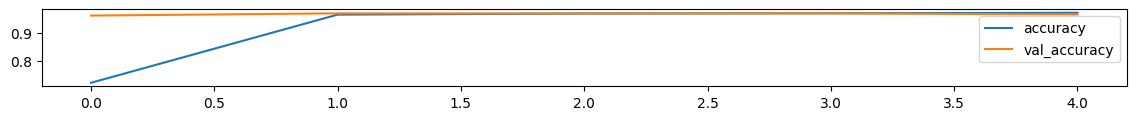

In [9]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


Estrategia 3: rede profunda pre-treinada 

In [10]:
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFBertForPreTraining
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
from transformers import BertTokenizer

def deep_cnn_embedding_softmax_model_bert(vocab_size=vocab_size, number_of_ngrams=24, n_gram_size=4):
    # input_layer = Input(shape=(1,), dtype=tf.string)
    # x = input_layer
    # x = tokenizer(x, padding=True, truncation=True, return_tensors='tf')
    # x = Embedding(vocab_size, 2, name='projecao')(x)

    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = tokenizer(x['input_ids'], x['attention_mask'], padding='longest', truncation=True, return_tensors='tf')
    x = Embedding(vocab_size, 2, name='projecao')(x)
    #abaixo estamos fazendo N gramas de N gramas, juntna as palavras em N gramas e depois junta esses N gramas em N gramas ate termos um grande N grama de X palavras.
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x = convolve_and_downsample(128, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(64, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(32, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(16, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(8, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(4, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(2, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = Reshape( (-1,))(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

# # Initialize the BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# X_train, y_train, X_test, y_test = train_test()

# Convert input text to tokenized sequences using the BERT tokenizer
# X_train = tokenizer(X_train, padding=True, truncation=True, return_tensors='tf')
# X_test = tokenizer(X_test, padding=True, truncation=True, return_tensors='tf')

# Convert input text to tokenized sequences using the BERT tokenizer
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train, y_train, X_test, y_test = train_test()

# Extract values from the input tensors
X_train_input_ids = X_train['input_ids'].numpy().tolist()
X_train_attention_mask = X_train['attention_mask'].numpy().tolist()
X_test_input_ids = X_test['input_ids'].numpy().tolist()
X_test_attention_mask = X_test['attention_mask'].numpy().tolist()

# Convert input text to tokenized sequences using the BERT tokenizer
X_train = tokenizer(X_train_input_ids, X_train_attention_mask, padding='longest', truncation=True, return_tensors='tf')
X_test = tokenizer(X_test_input_ids, X_test_attention_mask, padding='longest', truncation=True, return_tensors='tf')


# vectorize_layer = None  # Remove the TextVectorization layer

# clf2 = deep_cnn_embedding_softmax_model_bert()
# history = clf2.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.1)

# # Evaluate the model on the test data
# loss, accuracy = clf2.evaluate(X_test, y_test)

# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

clf2 = deep_cnn_embedding_softmax_model_bert()
history = clf2.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy = clf2.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


TypeError: list indices must be integers or slices, not str

In [12]:
X_train, y_train, X_test, y_test = train_test()


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForPreTraining.from_pretrained("bert-base-uncased")
input_ids = tokenizer(X_train, add_special_tokens=True, return_tensors="tf", padding=True)
# Batch size 1

# outputs = model(input_ids)
# prediction_logits, seq_relationship_logits = outputs[:2]

All model checkpoint layers were used when initializing TFBertForPreTraining.

All the layers of TFBertForPreTraining were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


TypeError: 'BatchEncoding' object is not callable

In [22]:
from transformers import pipeline, set_seed, GPT2Tokenizer, TFGPT2Model
import re

In [18]:
def gpt2_generate(command):
    match = re.match(r"!gpt2_generate:(.+)", command)
    content = match.group(1)

    generator = pipeline('text-generation', model='gpt2')
    set_seed(42)
    gpt_output = generator(content, max_length=80, num_return_sequences=1)

    generated_text = gpt_output[0]['generated_text']  # Access the generated text from the output
    return generated_text
    # return extract_after_first_string(generated_text, content)


In [19]:
print(gpt2_generate("!gpt2_generate: make me a poem about a 1997 honda accord"))

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 make me a poem about a 1997 honda accordion accident. The whole series is all on the Internet at http://puu.sh/z6sKM. In another post about the incident, she states that she found a text message from one of her friends who is also an accordion player in a room. She says that the text wasn't about the accordion and that he


In [24]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)
print(output)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


TFBaseModelOutputWithPastAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
array([[[ 0.16290489, -0.21657318, -0.14102808, ..., -0.26188615,
         -0.08190847,  0.00923971],
        [ 0.4627966 ,  0.02483836, -0.07853654, ..., -0.08585799,
          0.5122235 , -0.39390486],
        [-0.06436864,  0.15511829, -0.6305844 , ...,  0.24878453,
          0.36905366,  0.08326849],
        ...,
        [-0.55908126, -0.44902438, -1.4539908 , ...,  0.16498989,
         -0.1302289 , -0.3740275 ],
        [ 0.14001597, -0.38752824, -0.79156256, ..., -0.17796806,
          0.18236107,  0.21849138],
        [ 0.17207064, -0.2420471 , -0.11238768, ..., -0.10684206,
          0.12054686, -0.32129446]]], dtype=float32)>, past_key_values=(<tf.Tensor: shape=(2, 1, 12, 10, 64), dtype=float32, numpy=
array([[[[[-1.07186723e+00,  2.41698933e+00,  9.66034114e-01, ...,
           -4.78705704e-01, -3.31556886e-01,  1.79252303e+00],
          [-2.28969359e+00,  2.54